In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/home/federico/Università/Tesi_magistrale/my_programs/')

from contact_matrix_utils import *
from settings import *
from src.slice_pairwise import *
from src.interchromosomal_cosegregation import *
from src.slice_pairwise_inter_beta_evaluation import *
from numpy.random import Generator, MT19937
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import squareform
from src.utilities import compute_tube_segregation_frequency_inter

plt.style.use('default')

In [2]:
save_folder = "/home/federico/Università/Tesi_magistrale/images/11_beta_calculation_150kb.ipynb_output/"

# Data preparation and info #

In [3]:
#1NP
name_root_1NP_150kb = "mesc_46C_150kb_481x1"
path_1 =      r"/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/" + name_root_1NP_150kb + "/"
file_name_1 = "segregation_" + name_root_1NP_150kb +  ".pkl"
with open(path_1 + file_name_1, 'rb') as f_1:
    segregation_table_1NP = pickle.load(f_1)

# gw_coseg_matrix_1NP = compute_coseg_genomewide(segregation_table_1NP, 1, 19)


In [4]:
#3NP
name_root_3NP_150kb = "iza-mesc_150kb_420x3"
path_2 =      r"/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/" + name_root_3NP_150kb + "/"
file_name_2 = "segregation_" + name_root_3NP_150kb +  ".pkl"
with open(path_2 + file_name_2, 'rb') as f_2:
    segregation_table_3NP = pickle.load(f_2)

#gw_coseg_matrix_3NP = compute_coseg_genomewide(segregation_table_3NP, 1, 19)


In [5]:
#3NP
name_root_3NP_150kb_dopa = "dopa30_150kb_482x3"
path_2 =      r"/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/" + name_root_3NP_150kb_dopa + "/"
file_name_2 = "segregation_" + name_root_3NP_150kb_dopa +  ".pkl"
with open(path_2 + file_name_2, 'rb') as f_2:
    segregation_table_3NP_150kb_dopa = pickle.load(f_2)


In [6]:
start_chr, stop_chr = 1, 19
stop_chr += 1
chromosomes = []
n_chromosomes = stop_chr - start_chr

l = []
size = 0

for i in range(start_chr, stop_chr):
    chrA = 'chr' + str(i)
    chromosomes += [chrA]
    s = segregation_table_1NP[chrA]['segregation_table'].shape[0]
    size += s
    l.append(s) 

chr_windows_sizes_150kb = np.array(l)



# inter $\beta$ for mESC 1NP #

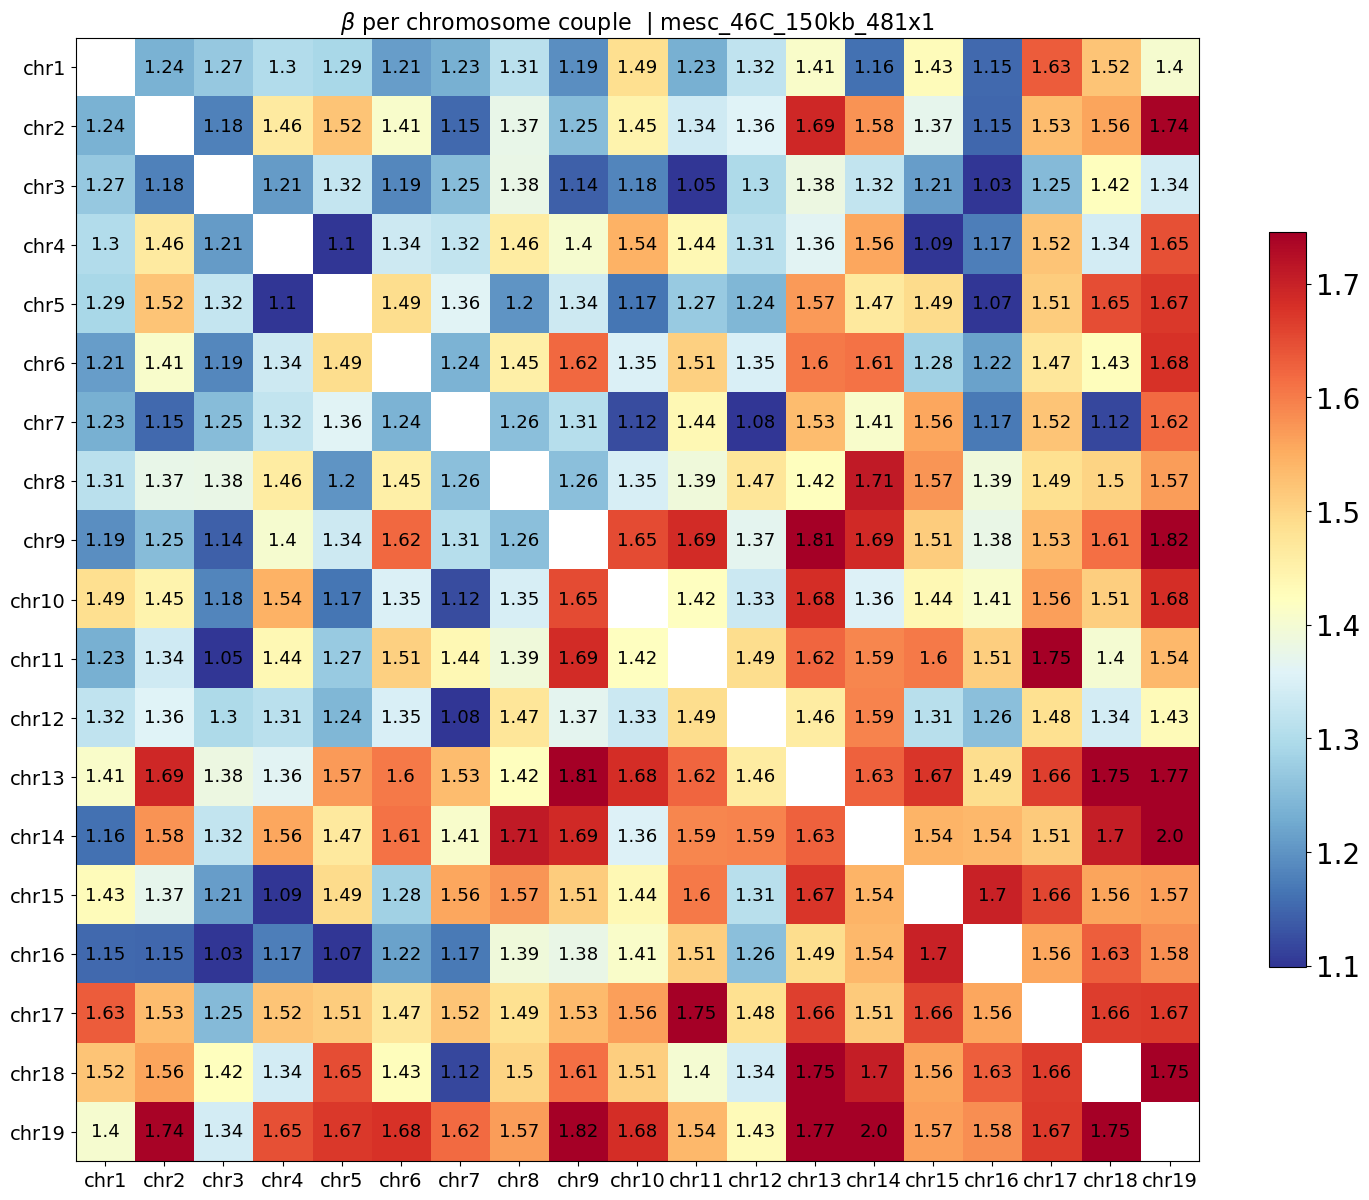

In [11]:
F_arr_genomewide = np.array([])
chr_list = list(dict({"chr1": 1, "chr2": 2, "chr3": 3, "chr4": 4,
                             "chr5": 5, "chr6": 6, "chr7": 7, "chr8": 8,
                             "chr9": 9, "chr10": 10, "chr11": 11, "chr12": 12,
                             "chr13": 13, "chr14": 14, "chr15": 15, "chr16": 16,
                             "chr17": 17, "chr18": 18, "chr19": 19}).keys())

# For each chromosome, compute F_arr and store it in F_arr_genomewide
for chr in chr_list:
    
    segregation_table = segregation_table_1NP[chr]["segregation_table"]
    F_arr = compute_tube_segregation_frequency(segregation_table)
    F_arr_genomewide = np.concatenate((F_arr_genomewide, F_arr))
    del F_arr

# Print result
F_mean_1NP_150kb = np.nanmean(F_arr_genomewide)

#F_mean_1NP_150kb = 0.4876928549197457
del F_arr_genomewide

beta_1NP_150kb = np.zeros((19,19)) * np.nan

for i in range(n_chromosomes):
    for j in range(i, n_chromosomes):
        if(i!=j):
            chrA_1NP_150kb_seg_freq, chrB_1NP_150kb_seg_freq = compute_tube_segregation_frequency_inter(segregation_table_1NP[chr_list[i]]['segregation_table'], segregation_table_1NP[chr_list[j]]['segregation_table'])
            start_row    = np.sum(chr_windows_sizes_150kb[:i])
            stop_row     = start_row + chr_windows_sizes_150kb[i]
            start_column = np.sum(chr_windows_sizes_150kb[:j])
            stop_column  = start_column + chr_windows_sizes_150kb[j]

            #chrA_chrB_coseg_1NP_150kb = np.copy(gw_coseg_matrix_1NP[start_row:stop_row, start_column:stop_column])
            chrA_chrB_coseg_1NP_150kb =  compute_tube_cosegregation_matrix_offdiag(segregation_table_1NP[chr_list[i]]['segregation_table'], segregation_table_1NP[chr_list[j]]['segregation_table'])

            F_i_1NP_150kb = np.tile(chrA_1NP_150kb_seg_freq, (len(chrB_1NP_150kb_seg_freq), 1)).T
            F_j_1NP_150kb = np.tile(chrB_1NP_150kb_seg_freq, (len(chrA_1NP_150kb_seg_freq), 1))
            F_i_plus_F_j_1NP_150kb = F_i_1NP_150kb + F_j_1NP_150kb            

            chrA_chrB_coseg_1NP_150kb[:, np.isnan(chrB_1NP_150kb_seg_freq)] = np.nan
            chrA_chrB_coseg_1NP_150kb[np.isnan(chrA_1NP_150kb_seg_freq), :] = np.nan

            R_ij_1NP_150kb = chrA_chrB_coseg_1NP_150kb / (F_i_plus_F_j_1NP_150kb - chrA_chrB_coseg_1NP_150kb)

            beta_1NP_150kb[i,j] = np.nanmean(scialdone_equation_for_s_mat(R_ij_1NP_150kb,  K = 2, F = F_mean_1NP_150kb))
            

        if(i==j):
            beta_1NP_150kb[i,j] = np.nan

for i in range(n_chromosomes):
    for j in range(i):
        beta_1NP_150kb[i,j] = beta_1NP_150kb[j,i]

fig, ax, c, _ = plot_heatmap(beta_1NP_150kb, x_figsize= 15, y_figsize= 15, colormap="RdYlBu_r")

for i in range(19):
    for j in range(19):
        if(i!=j):
            text = ax.text(j, i, np.around(beta_1NP_150kb[i, j], decimals=2),
                           ha="center", va="center", color="black", fontsize = 13)
        else:
            text = ax.text(j, i, np.around(beta_1NP_150kb[i, j], decimals=2),
                           ha="center", va="center", color="white", fontsize = 13)

ax.set_title("$\\beta$ per chromosome couple " + " | " + name_root_1NP_150kb, fontsize = 16)
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
c.ax.tick_params(axis='y', which='major', labelsize=20)

fig.tight_layout()

fig.savefig(save_folder + 'beta_mesc_1NP_150kb.svg' , format = 'svg', dpi = 300)

del fig, ax, F_mean_1NP_150kb, chrA_1NP_150kb_seg_freq, chrB_1NP_150kb_seg_freq, chrA_chrB_coseg_1NP_150kb, F_i_1NP_150kb, F_j_1NP_150kb, F_i_plus_F_j_1NP_150kb

# inter $\beta$ for mESC 3NP #

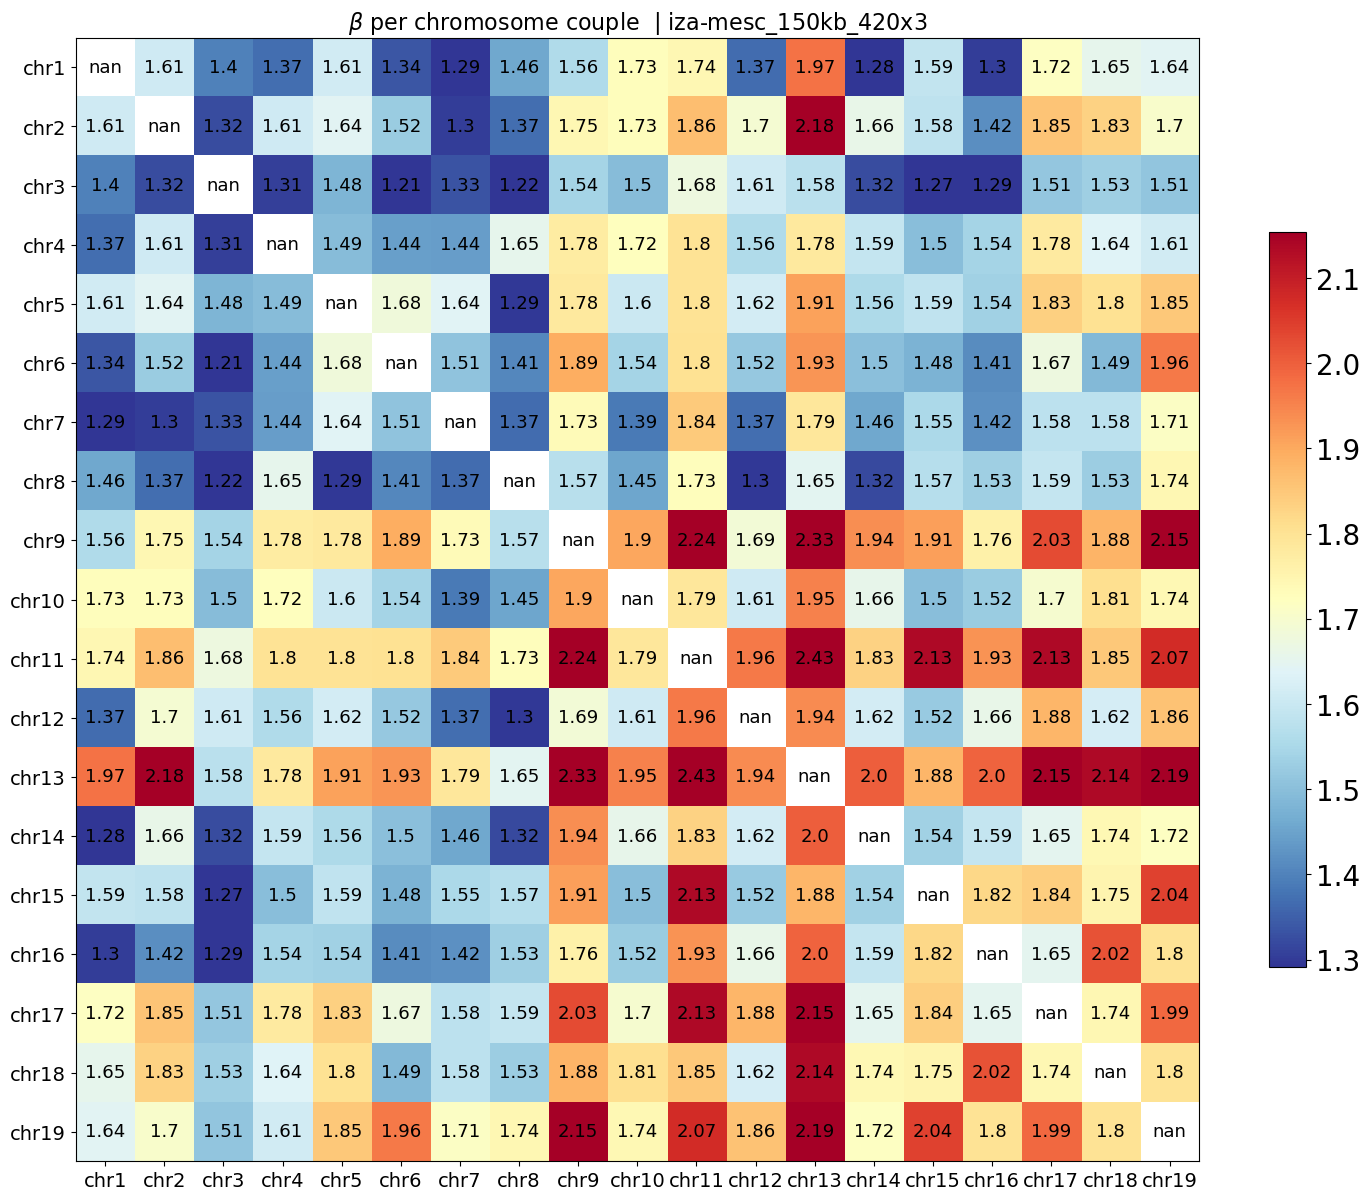

In [8]:
F_arr_genomewide = np.array([])
chr_list = list(dict({"chr1": 1, "chr2": 2, "chr3": 3, "chr4": 4,
                             "chr5": 5, "chr6": 6, "chr7": 7, "chr8": 8,
                             "chr9": 9, "chr10": 10, "chr11": 11, "chr12": 12,
                             "chr13": 13, "chr14": 14, "chr15": 15, "chr16": 16,
                             "chr17": 17, "chr18": 18, "chr19": 19}).keys())

# For each chromosome, compute F_arr and store it in F_arr_genomewide
for chr in chr_list:
    
    segregation_table = segregation_table_3NP[chr]["segregation_table"]
    F_arr = compute_tube_segregation_frequency(segregation_table)
    F_arr_genomewide = np.concatenate((F_arr_genomewide, F_arr))
    del F_arr

# Print result
F_mean_3NP_150kb = np.nanmean(F_arr_genomewide)

#F_mean_3NP_150kb = 0.4876928549197457
del F_arr_genomewide

beta_3NP_150kb = np.zeros((19,19))

for i in range(n_chromosomes):
    for j in range(i, n_chromosomes):
        if(i!=j):
            chrA_3NP_150kb_seg_freq, chrB_3NP_150kb_seg_freq = compute_tube_segregation_frequency_inter(segregation_table_3NP[chr_list[i]]['segregation_table'], segregation_table_3NP[chr_list[j]]['segregation_table'])
            start_row    = np.sum(chr_windows_sizes_150kb[:i])
            stop_row     = start_row + chr_windows_sizes_150kb[i]
            start_column = np.sum(chr_windows_sizes_150kb[:j])
            stop_column  = start_column + chr_windows_sizes_150kb[j]

            #chrA_chrB_coseg_3NP_150kb = np.copy(gw_coseg_matrix_3NP[start_row:stop_row, start_column:stop_column])
            chrA_chrB_coseg_3NP_150kb =  compute_tube_cosegregation_matrix_offdiag(segregation_table_3NP[chr_list[i]]['segregation_table'], segregation_table_3NP[chr_list[j]]['segregation_table'])


            F_i_3NP_150kb = np.tile(chrA_3NP_150kb_seg_freq, (len(chrB_3NP_150kb_seg_freq), 1)).T
            F_j_3NP_150kb = np.tile(chrB_3NP_150kb_seg_freq, (len(chrA_3NP_150kb_seg_freq), 1))
            F_i_plus_F_j_3NP_150kb = F_i_3NP_150kb + F_j_3NP_150kb

            chrA_chrB_coseg_3NP_150kb[:, np.isnan(chrB_3NP_150kb_seg_freq)] = np.nan
            chrA_chrB_coseg_3NP_150kb[np.isnan(chrA_3NP_150kb_seg_freq), :] = np.nan

            R_ij_3NP_150kb = chrA_chrB_coseg_3NP_150kb / (F_i_plus_F_j_3NP_150kb - chrA_chrB_coseg_3NP_150kb)

            beta_3NP_150kb[i,j] = np.nanmean(scialdone_equation_for_s_mat(R_ij_3NP_150kb,  K = 6, F = F_mean_3NP_150kb))
            

        if(i==j):
            beta_3NP_150kb[i,j] = np.nan

for i in range(n_chromosomes):
    for j in range(i):
        beta_3NP_150kb[i,j] = beta_3NP_150kb[j,i]

fig, ax, c, _ = plot_heatmap(beta_3NP_150kb, x_figsize= 15, y_figsize= 15, colormap="RdYlBu_r")

for i in range(19):
    for j in range(19):
        text = ax.text(j, i, np.around(beta_3NP_150kb[i, j], decimals=2),
                       ha="center", va="center", color="black", fontsize = 13)


ax.set_title("$\\beta$ per chromosome couple " + " | " + name_root_3NP_150kb, fontsize = 16)
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
c.ax.tick_params(axis='y', which='major', labelsize=20)

fig.tight_layout()

fig.savefig(save_folder + 'beta_mesc_3NP_150kb.svg' , format = 'svg', dpi = 300)

del fig, ax, F_mean_3NP_150kb, chrA_3NP_150kb_seg_freq, chrB_3NP_150kb_seg_freq, chrA_chrB_coseg_3NP_150kb, F_i_3NP_150kb, F_j_3NP_150kb, F_i_plus_F_j_3NP_150kb

# inter $\beta$ for Dopa 3NP #

In [9]:
start_chr, stop_chr = 1, 19
stop_chr += 1
chromosomes = []
n_chromosomes = stop_chr - start_chr

l = []
size = 0

for i in range(start_chr, stop_chr):
    chrA = 'chr' + str(i)
    chromosomes += [chrA]
    s = segregation_table_3NP_150kb_dopa[chrA]['segregation_table'].shape[0]
    size += s
    l.append(s) 

chr_windows_sizes_150kb = np.array(l)



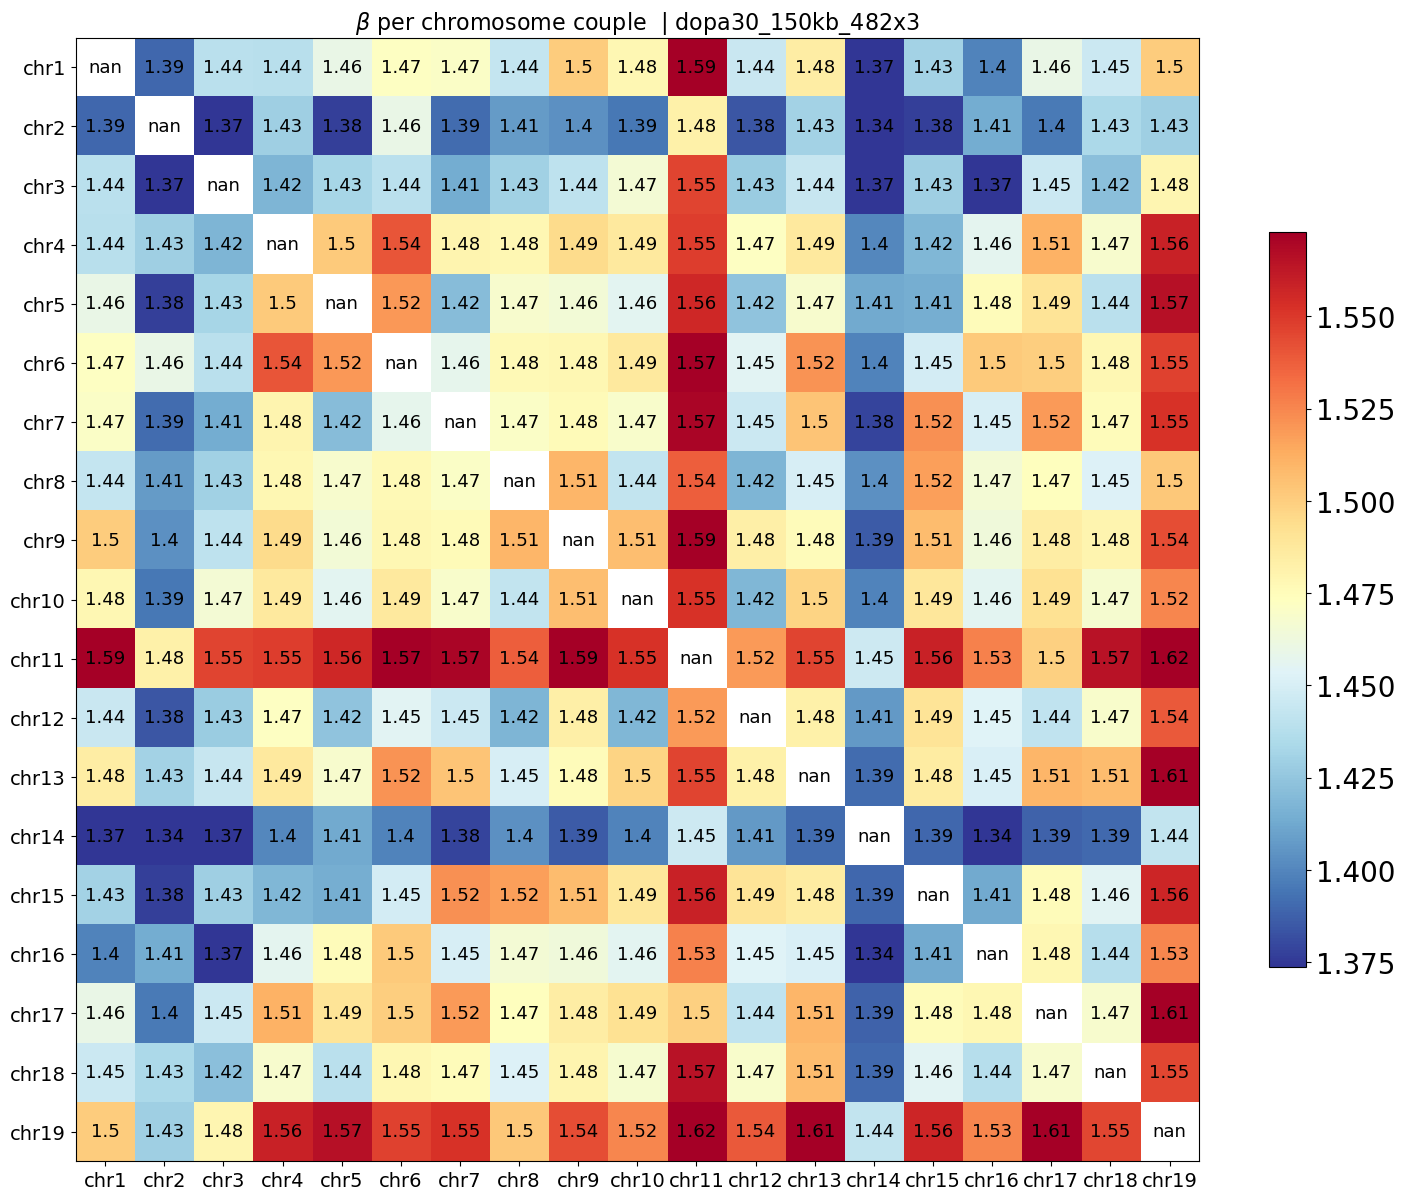

In [10]:
F_arr_genomewide = np.array([])
chr_list = list(dict({"chr1": 1, "chr2": 2, "chr3": 3, "chr4": 4,
                             "chr5": 5, "chr6": 6, "chr7": 7, "chr8": 8,
                             "chr9": 9, "chr10": 10, "chr11": 11, "chr12": 12,
                             "chr13": 13, "chr14": 14, "chr15": 15, "chr16": 16,
                             "chr17": 17, "chr18": 18, "chr19": 19}).keys())

# For each chromosome, compute F_arr and store it in F_arr_genomewide
for chr in chr_list:
    
    segregation_table = segregation_table_3NP_150kb_dopa[chr]["segregation_table"]
    F_arr = compute_tube_segregation_frequency(segregation_table)
    F_arr_genomewide = np.concatenate((F_arr_genomewide, F_arr))
    del F_arr

# Print result
F_mean_3NP_150kb_dopa = np.nanmean(F_arr_genomewide)

#F_mean_1NP_150kb = 0.4876928549197457
del F_arr_genomewide

beta_3NP_150kb_dopa = np.zeros((19,19)) * np.nan

for i in range(n_chromosomes):
    for j in range(i, n_chromosomes):
        if(i!=j):
            chrA_3NP_150kb_dopa_seg_freq, chrB_3NP_150kb_dopa_seg_freq = compute_tube_segregation_frequency_inter(segregation_table_3NP_150kb_dopa[chr_list[i]]['segregation_table'], segregation_table_3NP_150kb_dopa[chr_list[j]]['segregation_table'])
            start_row    = np.sum(chr_windows_sizes_150kb[:i])
            stop_row     = start_row + chr_windows_sizes_150kb[i]
            start_column = np.sum(chr_windows_sizes_150kb[:j])
            stop_column  = start_column + chr_windows_sizes_150kb[j]

            chrA_chrB_coseg_3NP_150kb_dopa =  compute_tube_cosegregation_matrix_offdiag(segregation_table_3NP_150kb_dopa[chr_list[i]]['segregation_table'], segregation_table_3NP_150kb_dopa[chr_list[j]]['segregation_table'])

            F_i_3NP_150kb_dopa = np.tile(chrA_3NP_150kb_dopa_seg_freq, (len(chrB_3NP_150kb_dopa_seg_freq), 1)).T
            F_j_3NP_150kb_dopa = np.tile(chrB_3NP_150kb_dopa_seg_freq, (len(chrA_3NP_150kb_dopa_seg_freq), 1))
            F_i_plus_F_j_3NP_150kb_dopa = F_i_3NP_150kb_dopa + F_j_3NP_150kb_dopa            

            chrA_chrB_coseg_3NP_150kb_dopa[:, np.isnan(chrB_3NP_150kb_dopa_seg_freq)] = np.nan
            chrA_chrB_coseg_3NP_150kb_dopa[np.isnan(chrA_3NP_150kb_dopa_seg_freq), :] = np.nan

            R_ij_3NP_150kb_dopa = chrA_chrB_coseg_3NP_150kb_dopa / (F_i_plus_F_j_3NP_150kb_dopa - chrA_chrB_coseg_3NP_150kb_dopa)

            beta_3NP_150kb_dopa[i,j] = np.nanmean(scialdone_equation_for_s_mat(R_ij_3NP_150kb_dopa,  K = 2, F = F_mean_3NP_150kb_dopa))
            

        if(i==j):
            beta_3NP_150kb_dopa[i,j] = np.nan

for i in range(n_chromosomes):
    for j in range(i):
        beta_3NP_150kb_dopa[i,j] = beta_3NP_150kb_dopa[j,i]

fig, ax, c, _ = plot_heatmap(beta_3NP_150kb_dopa, x_figsize= 15, y_figsize= 15, colormap="RdYlBu_r")

for i in range(19):
    for j in range(19):
        text = ax.text(j, i, np.around(beta_3NP_150kb_dopa[i, j], decimals=2),
                       ha="center", va="center", color="black", fontsize = 13)

ax.set_title("$\\beta$ per chromosome couple " + " | " + name_root_3NP_150kb_dopa, fontsize = 16)
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
c.ax.tick_params(axis='y', which='major', labelsize=20)

fig.tight_layout()

fig.savefig(save_folder + 'beta_dopa_3NP_150kb.svg' , format = 'svg', dpi = 300)

del R_ij_3NP_150kb_dopa, F_mean_3NP_150kb_dopa, chrA_3NP_150kb_dopa_seg_freq, chrB_3NP_150kb_dopa_seg_freq, chrA_chrB_coseg_3NP_150kb_dopa, F_i_3NP_150kb_dopa, F_j_3NP_150kb_dopa, F_i_plus_F_j_3NP_150kb_dopa